We replot the heatmap to adjust for journal layout

In [ ]:
#Import data from combined_result

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import re

warnings.simplefilter("ignore")

newest_file = "2024-04-21_004417"
experiment_name = "corr"
dist_dict_path = "distance_dict"
alpha = 0.5

list_dataset = [
                "Lastfm",
                "Amazon-lb", 
                "QK-video",
                "Jester",
                "ML-10M",
                "ML-20M"
                ]

rel_measures = ["P@10", "MAP@10", "R@10", "NDCG@10"]
fair_measures = ["Jain_our@10", "Ent_our@10", "Gini_our@10"]


plt.rcParams['figure.dpi'] = 400
plt.rcParams['savefig.dpi'] = 600


# Correlation

In [13]:
model_scores = pd.read_csv(f"{experiment_name}/model_scores.csv", index_col=0)
model_scores

,source,AI-F_ori@10,Ent_our@10,Gini_our@10,IAA_true_ori@10,IBO_our@10,II-F_ori@10,Jain_our@10,MAP@10,MME_ori@10,NDCG@10,P@10,R@10
dataset,,,,,,,,,,,,,
Amazon-lb,BPR,0.000327,0.746980,0.746800,0.011300,0.019139,0.005688,0.222596,0.002025,0.001003,0.003228,0.001373,0.005435
Amazon-lb,BPR-BC,0.000234,0.839115,0.600567,0.011292,0.028708,0.005682,0.431615,0.003485,0.000744,0.004925,0.001373,0.007532
Amazon-lb,BPR-CM,0.000244,0.809428,0.660077,0.011292,0.038278,0.005680,0.358523,0.004335,0.000760,0.006370,0.002059,0.010278
Amazon-lb,BPR-GS,0.000316,0.776303,0.702932,0.011300,0.019139,0.005688,0.258864,0.002025,0.000997,0.003228,0.001373,0.005435
Amazon-lb,ItemKNN,0.000294,0.802021,0.664811,0.011228,0.062201,0.005649,0.271328,0.006094,0.001011,0.010973,0.005034,0.013440
...,...,...,...,...,...,...,...,...,...,...,...,...,...
QK-video,MultiVAE-GS,0.000051,0.457582,0.975616,0.001144,0.032675,0.000656,0.014100,0.017391,0.000242,0.030122,0.010899,0.047364
QK-video,NCL,0.000035,0.507278,0.965565,0.001139,0.042916,0.000653,0.020076,0.021764,0.000243,0.038090,0.014001,0.060801
QK-video,NCL-BC,0.000005,0.667371,0.909017,0.001148,0.060229,0.000659,0.075834,0.012823,0.000189,0.025319,0.010757,0.045233


In [16]:
combined_df_full = pd.read_csv("corr/combined_df_full.csv")
model_distance_dict_full = pd.read_pickle(f"{dist_dict_path}/model_distance_dict_full-alpha-{alpha}.pickle")

In [ ]:
def get_avg(this_data):

    for_val = this_data.loc[this_data.source!="pareto"]
    for_val_rel = for_val[rel_measures]
    for_val_fair = for_val[fair_measures]
    for_val_fair.loc[:,for_val_fair.columns.str.contains("Gini")] = 1 - for_val_fair.loc[:,for_val_fair.columns.str.contains("Gini")]

    df_average = pd.DataFrame(columns=["rel", "fair", "score", "source"])

    for col in for_val_fair.columns:
        avg_val_for_col = (for_val_rel.values + for_val_fair[col].values.reshape(-1,1))/2
        df_avg_col = pd.DataFrame(avg_val_for_col, columns=rel_measures)
        df_avg_col["source"] = for_val.source.values
        df_avg_col["fair"] = col
        melted = df_avg_col.melt(["fair", "source"], var_name="rel", value_name="score")
        df_average = pd.concat([df_average, melted])

    return df_average


def distance_based_rank_for_corr(model_distance_dict, data):
    rank_based_on_distance = model_distance_dict[data].unstack().reset_index()
    rank_based_on_distance.columns = ["rel","fair","models"]
    rank_based_on_distance = rank_based_on_distance.loc[rank_based_on_distance.rel.str.contains("^P|^R|NDCG|MAP")]
    rank_based_on_distance = rank_based_on_distance.loc[rank_based_on_distance.fair.str.contains("Jain|Gini|Ent")]
    rank_based_on_distance = rank_based_on_distance.loc[rank_based_on_distance.fair.str.contains("our")]
    rank_based_on_distance = rank_based_on_distance.loc[rank_based_on_distance.models.apply(lambda x: x[1]).dropna().index]
    rank_based_on_distance["col_name"] = rank_based_on_distance.rel + "-" + rank_based_on_distance.fair
    rank_based_on_distance = rank_based_on_distance[["col_name","models"]].T
    rank_based_on_distance.columns = rank_based_on_distance.loc["col_name"]
    rank_based_on_distance = rank_based_on_distance.iloc[1].T
    
    dict_rank_based_on_distance = {}

    for row, item in pd.DataFrame(rank_based_on_distance).iterrows():
        the_tup = item[0]
        model_name = the_tup[0]
        scores = the_tup[1]
        dict_rank_based_on_distance[row] = dict((key,val) for key,val in zip(model_name, scores))


    for_corr = pd.DataFrame(dict_rank_based_on_distance).T.applymap(lambda x: -x)

    return for_corr


def plot_corr_heatmap(combined_df, model_distance_dict, model_scores):
    fig, ax = plt.subplots(nrows=3,ncols=2, figsize=(12,10), sharex=False, sharey=False)

    i=0
    for ax_id, data in zip(ax.flatten(), list_dataset):

        #rank based on measure
        rank_based_on_measure = {}
        model_scores_for_data = model_scores.query("dataset==@data")

        for col in model_scores_for_data.columns:
            if col in ["dataset", "source"]:
                pass
            else:
                if bool(re.search('AI|II|IAA|MME', col)):
                    sorted = model_scores_for_data.sort_values(col, ascending=True, kind="stable")
                    print(f"sorting {col} ascendingly")
                elif bool(re.search('IBO', col)):
                    sorted = model_scores_for_data.sort_values(col, ascending=False, kind="stable")
                    print(f"sorting {col} descendingly")
                else:
                    continue
                rank_based_on_measure[col] = sorted.source.values

        rank_based_on_measure = pd.DataFrame(rank_based_on_measure)

        for_corr = model_scores_for_data.loc[:,model_scores_for_data.columns.str.contains("AI|II|IAA|IBO|MME|source")]
        for_corr = for_corr.loc[:, ~for_corr.columns.str.contains("IBO_ori|IWO_ori")]
        for_corr = for_corr.T
        for_corr.columns = for_corr.loc["source"]
        for_corr.drop(index=["source"], inplace=True)

        for_corr.loc[for_corr.index.str.contains("AI|IAA|II|MME")] = for_corr.loc[for_corr.index.str.contains("AI|IAA|II|MME")].apply(lambda x: -x)

        to_append = distance_based_rank_for_corr(model_distance_dict, data)
        for_corr_appended = pd.concat([for_corr, to_append])

        #avg = higher score is better, so no need to invert
        this_data = combined_df.query("dataset==@data")
        avg = get_avg(this_data)
        avg["rel_fair"] = avg["rel"] + "-" + avg["fair"]
        avg = avg.drop(columns=["rel", "fair"])
        avg = avg.set_index("rel_fair")

        avg.index = avg.index.str.replace("@10","") + "-avg"
        avg_to_append = avg.pivot(columns="source", values="score")
        for_corr_appended = pd.concat([for_corr_appended,avg_to_append])


        #plotting
        to_plot = for_corr_appended.T.reset_index(drop=True).applymap(float).corr(method="kendall").round(2)
        to_plot.dropna(how="all",inplace=True, axis=1)
        to_plot.dropna(how="all",inplace=True, axis=0)
        to_plot.columns = to_plot.columns.str.replace("@10", "")
        to_plot.index = to_plot.index.str.replace("@10","")

        #do the indexing automatically
        idx_index = to_plot.columns.tolist().index("MME_ori") +1
        idx_col = to_plot.index.tolist().index("MME_ori") +1


        filtered = to_plot.iloc[idx_index:, :idx_col]
        wo_avg = filtered[~filtered.index.str.contains("avg")]
        wo_avg["avg"] = pd.Series()
        only_avg = to_plot.loc[~to_plot.index.str.contains("AI|IAA|II|IBO|MME"),to_plot.columns.str.contains("avg")]

        for pair in wo_avg.index:
            wo_avg.loc[pair, "avg"] = only_avg.loc[pair, pair+"-avg"]

        wo_avg = wo_avg.T
        wo_avg.index = wo_avg.index\
                                .str.replace("_ori","")\
                                .str.replace("_our","")\
                                .str.replace("_true","")
        wo_avg.columns = wo_avg.columns\
                                .str.replace("_ori","")\
                                .str.replace("_our","")\

        wo_avg = wo_avg.loc[["IBO", "MME", "IAA", "II-F", "AI-F", "avg"]]

        wo_avg = wo_avg.astype(float)
        
        sns.heatmap(wo_avg,
                    annot=True,
                    cmap="coolwarm_r",
                    vmin = -1,
                    vmax = 1,
                    square = True,
                    ax = ax_id,
                    cbar = True,
                    # cbar = i % 2==1,
                    annot_kws={"size": 10},
                    cbar_kws={"shrink": 0.875}
                    )
        ax_id.set_yticklabels(ax_id.get_yticklabels(), rotation=0)
        # if data != list_dataset[-1]:
        #    ax_id.set_xticklabels([])
        ax_id.set_title(f"{data}")
        ax_id.set_xlabel("DPFR")
        ax_id.set_ylabel("JOINT (existing)")
        i+=1

    plt.tight_layout(h_pad=6.5, w_pad=2)
    plt.savefig(f'corr/corr_heatmap_all_grid.pdf', bbox_inches="tight")
    plt.show()
    plt.close()
   


sorting AI-F_ori@10 ascendingly
sorting IAA_true_ori@10 ascendingly
sorting IBO_our@10 descendingly
sorting II-F_ori@10 ascendingly
sorting MME_ori@10 ascendingly
sorting AI-F_ori@10 ascendingly
sorting IAA_true_ori@10 ascendingly
sorting IBO_our@10 descendingly
sorting II-F_ori@10 ascendingly
sorting MME_ori@10 ascendingly
sorting AI-F_ori@10 ascendingly
sorting IAA_true_ori@10 ascendingly
sorting IBO_our@10 descendingly
sorting II-F_ori@10 ascendingly
sorting MME_ori@10 ascendingly
sorting AI-F_ori@10 ascendingly
sorting IAA_true_ori@10 ascendingly
sorting IBO_our@10 descendingly
sorting II-F_ori@10 ascendingly
sorting MME_ori@10 ascendingly
sorting AI-F_ori@10 ascendingly
sorting IAA_true_ori@10 ascendingly
sorting IBO_our@10 descendingly
sorting II-F_ori@10 ascendingly
sorting MME_ori@10 ascendingly
sorting AI-F_ori@10 ascendingly
sorting IAA_true_ori@10 ascendingly
sorting IBO_our@10 descendingly
sorting II-F_ori@10 ascendingly
sorting MME_ori@10 ascendingly


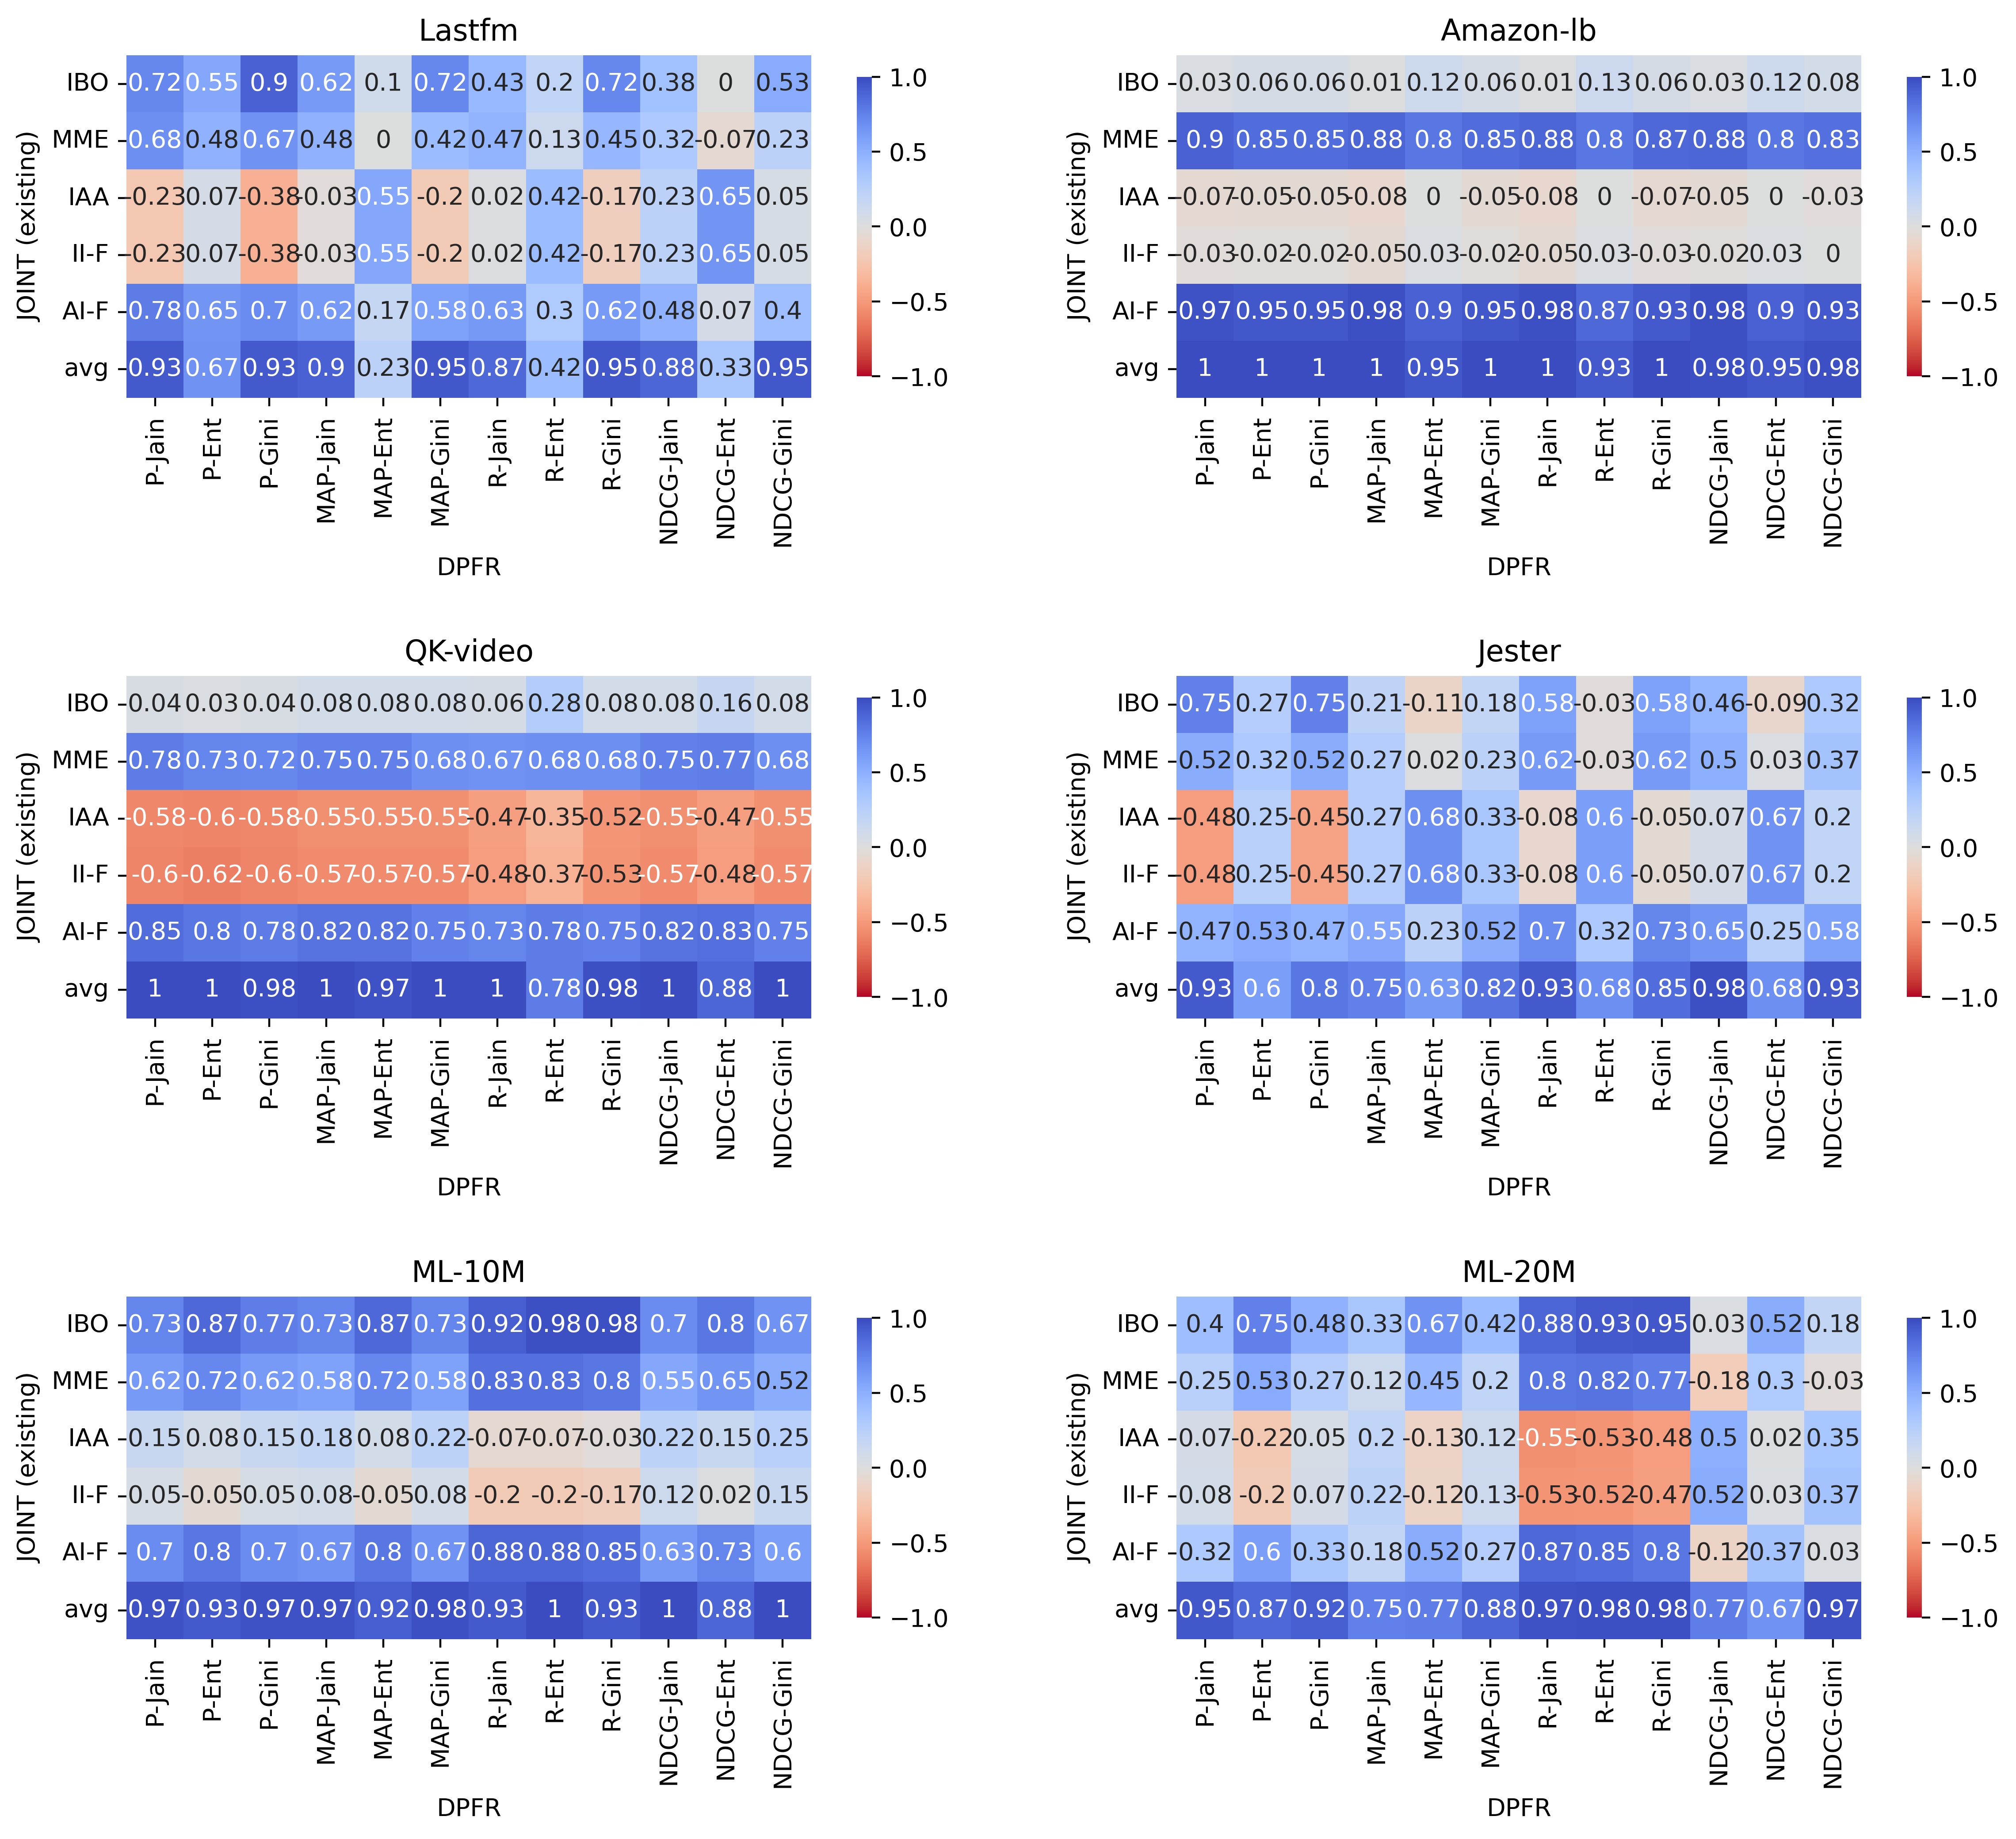

In [99]:
plot_corr_heatmap(combined_df_full, model_distance_dict_full, model_scores)